In [3]:
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from hyperparameters import AZ_HYPERPARAMETERS
import torch
from resnet2 import ResNet2Heads
from utils import input_to_tensor_3d, input_to_tensor, input_to_tensor_scalar
import torch.multiprocessing as mp
from train import save_checkpoint, load_from_checkpoint, test_network, GameReplayMemory, rotate_training_examples, train, collect_episode
from history import TrainingMetrics, Metric

import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

In [4]:
sum(p.numel() for p in ResNet2Heads().parameters() if p.requires_grad)

64037

In [5]:
MODEL_TO_LOAD = "" # place filename of checkpoint here, otherwise leave empty
LOAD_REPLAY_MEMORY = True
PLOT_EVERY = 10000
NUM_COLLECTION_PROCS = 4
NUM_TRAIN_PROCS = 1


# HYPERPARAMETERS (will be ignored if loading from a checkpoint)
hypers = AZ_HYPERPARAMETERS() # use kwargs to specify non-default values


In [6]:
if MODEL_TO_LOAD:
    model, optimizer, hypers, history, memory, run_tag = load_from_checkpoint(MODEL_TO_LOAD, ResNet2Heads, load_replay_memory=LOAD_REPLAY_MEMORY)
    history.reset_all_figs()
else:
    # Set any hyperparameters you want to change here
    

    # init model, replay memory, optimizer, and metrics history
    model = ResNet2Heads()
    memory = GameReplayMemory(hypers.replay_memory_size)
    optimizer = torch.optim.AdamW(model.parameters(), lr=hypers.learning_rate, weight_decay=hypers.weight_decay, amsgrad=True)
    history = TrainingMetrics(
        metrics=[
            Metric(name='loss', xlabel='Episode', ylabel='Loss', addons={'running_mean': 100}, maximize=False, alert_on_best=True),
            Metric(name='value_loss', xlabel='Episode', ylabel='Loss', addons={'running_mean': 100}, maximize=False, alert_on_best=True, proper_name='Value Loss'),
            Metric(name='policy_loss', xlabel='Episode', ylabel='Loss', addons={'running_mean': 100}, maximize=False, alert_on_best=True, proper_name='Policy Loss'),
            Metric(name='policy_accuracy', xlabel='Episode', ylabel='Accuracy (%)', addons={'running_mean': 100}, maximize=True, alert_on_best=True, proper_name='Policy Accuracy'),
            Metric(name='game_score', xlabel='Episode', ylabel='Score', addons={'running_mean': 100}, maximize=True, alert_on_best=False, proper_name='Game Score'),
            Metric(name='game_moves', xlabel='Episode', ylabel='Moves', addons={'running_mean': 100}, maximize=True, alert_on_best=True, proper_name='Game Moves'),
            Metric(name='high_square', xlabel='Episode', ylabel='High Square (log2)', addons={'running_mean': 100}, maximize=True, alert_on_best=False, proper_name='High Square'),
            Metric(name='avg_deviation', xlabel='Episode', ylabel='Turn', addons={'running_mean': 100}, maximize=True, alert_on_best=False, proper_name='Average Deviation'),
            Metric(name='avg_score', xlabel='Epoch', ylabel='Score', maximize=True, alert_on_best=False, proper_name='Average Score'),
            Metric(name='avg_moves', xlabel='Epoch', ylabel='Moves', maximize=True, alert_on_best=False, proper_name='Average Moves'),
            Metric(name='avg_high_square', xlabel='Epoch', ylabel='High Square (log2)', maximize=True, alert_on_best=False, proper_name='Average High Square'),
            Metric(name='std_moves', xlabel='Epoch', ylabel='Moves', maximize=False, alert_on_best=False, proper_name='Stddev Moves'),
        ],
        eval_metrics=[
            Metric(name='game_score', xlabel='Score', ylabel='Freq', pl_type='hist', maximize=True, alert_on_best=False, proper_name='Eval Game Scores'),
            Metric(name='game_moves', xlabel='Moves', ylabel='Freq', pl_type='hist', maximize=True, alert_on_best=True, proper_name='Eval Game Moves'),
            Metric(name='high_square', xlabel='High Square (log2)', ylabel='Freq', pl_type='hist', maximize=True, alert_on_best=False, proper_name='Eval High Square'),
        ]
    )
    run_tag = 'resnet64v2'     

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
def enque_and_train(results):
    torch.set_num_threads(NUM_TRAIN_PROCS)
    
    training_examples, reward, moves, high_square, avg_deviation, score = results
    training_examples = rotate_training_examples(training_examples)
    memory.insert(list(training_examples))
    
    if memory.size() >= hypers.replay_memory_min_size:
        cum_vl, cum_pl, cum_tl, cum_pa = 0.0, 0.0, 0.0, 0.0
        for i in range(hypers.minibatches_per_update):
            value_loss, prob_loss, total_loss, policy_acc = train(memory.sample(hypers.minibatch_size), model, optimizer, tensor_conversion_fn=input_to_tensor_scalar, \
                                                                  c_prob=hypers.policy_factor)
            cum_vl += value_loss
            cum_pl += prob_loss
            cum_tl += total_loss
            cum_pa += policy_acc
            
        cum_vl /= hypers.minibatches_per_update
        cum_pl /= hypers.minibatches_per_update
        cum_tl /= hypers.minibatches_per_update
        cum_pa /= hypers.minibatches_per_update

        history.add_episode_data({
            'loss': cum_tl,
            'value_loss': cum_vl,
            'policy_loss': cum_pl,
            'policy_accuracy': cum_pa,
            'game_score': score,
            'game_moves': moves,
            'high_square': high_square,
            'avg_deviation': avg_deviation
        }, print_data=True)

        if history.cur_episode % PLOT_EVERY == 0:
            history.generate_plots()
    else:
        print(f'Replay memory size not large enough, {memory.size()} < {hypers.replay_memory_min_size}')

def enque_eval_results(results):
    _, moves, high_square, score = results
    history.add_eval_data({
        'game_score': score,
        'game_moves': moves,
        'high_square': high_square
    })

In [ ]:
# populate replay memory
with mp.Pool(NUM_COLLECTION_PROCS) as p:
    results = []
    for _ in range(memory.size(), hypers.replay_memory_min_size - 1):
        results.append(p.apply_async(collect_episode, (model, hypers, input_to_tensor_scalar), callback=enque_and_train, error_callback=print))
    for r in results:
        r.wait()
    

for epoch in range(history.cur_epoch, hypers.num_epochs):
    prev_model = deepcopy(model)
    prev_optimizer = deepcopy(optimizer)
    print(f'Starting epoch {epoch}/{hypers.num_epochs}')
    print('Training...')
    with mp.Pool(NUM_COLLECTION_PROCS) as p:
        results = []
        for _ in range(history.cur_episode, hypers.episodes_per_epoch * epoch):
            results.append(p.apply_async(collect_episode, (model, hypers, input_to_tensor_scalar), callback=enque_and_train, error_callback=print))
        for r in results:
            r.wait()
    
    print('Testing...')
    with mp.Pool(NUM_COLLECTION_PROCS) as p:
        results = []
        for _ in range(hypers.eval_games):
            results.append(p.apply_async(test_network, (model, hypers, input_to_tensor_scalar), callback=enque_eval_results, error_callback=print))
        for r in results:
            r.wait()

    
    history.add_epoch_data({
        'avg_score': np.mean(history.eval_metrics['game_score'][-1].data),
        'avg_moves': np.mean(history.eval_metrics['game_moves'][-1].data),
        'avg_high_square': np.mean(history.eval_metrics['high_square'][-1].data),
        'std_moves': np.std(history.eval_metrics['game_moves'][-1].data)
    })

    # if model has not improved, load previous model
    if epoch > 0 and history.metrics['avg_moves'].data[-1] < history.metrics['avg_moves'].data[-2]:
        print('Model has not improved, reverting to previous model...')
        print('Previous model avg moves:', history.metrics['avg_moves'].data[-1])
        print('Current model avg moves:', history.metrics['avg_moves'].data[-2])
        model = prev_model
        optimizer = prev_optimizer


    history.generate_plots()
    
    print('Saving model checkpoint...')
    save_checkpoint(model, optimizer, hypers, history, memory, run_tag, save_replay_memory=True)
    print('Saved model checkpoint!')
    
        

In [10]:
hypers.replay_memory_min_size = 0
enque_and_train(collect_episode(model, hypers, input_to_tensor_scalar))

Episode 0
	Loss: 73.06212987436348
	Value Loss: 3.9527564346790314
	Policy Loss: 69.10937343968445
	Policy Accuracy: 0.35546875
	Game Score: 1276.0
	Game Moves: 136
	High Square: 7
	Average Deviation: 68.6923076923077
**** NEW BEST Loss: 73.06212987436348 ****
**** NEW BEST Value Loss: 3.9527564346790314 ****
**** NEW BEST Policy Loss: 69.10937343968445 ****
**** NEW BEST Policy Accuracy: 0.35546875 ****
**** NEW BEST Game Moves: 136 ****


/var/folders/bd/sfd5qw2j27v1b3ht5zx176l00000gn/T/ipykernel_25044/3362211688.py:3: RuntimeWarning: divide by zero encountered in log2
  plt.plot(np.linspace(0, 2000, 2000), np.log2(np.linspace(0, 2000, 2000)))


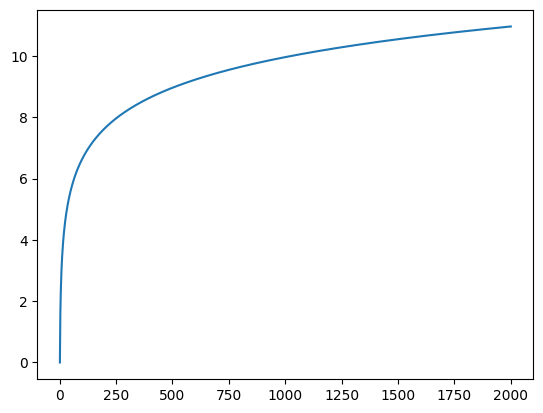

In [14]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.linspace(0, 2000, 2000), np.log2(np.linspace(0, 2000, 2000)))